In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import plotly.express as px
import numpy as np


In [ ]:
!pip install --upgrade plotly

In [ ]:
 pip install -U kaleido

In [18]:
brasil = gpd.read_file('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson')

In [19]:

df = pd.read_csv('microdados_ed_basica_2024.csv', delimiter=';', encoding='latin-1')

/tmp/ipython-input-19-3657218009.py:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('microdados_ed_basica_2024.csv', delimiter=';', encoding='latin-1')


## Preparo Inicial:


*   entender os tipos de dados
*   transformar os tipos de dados das colunas


*   modificar as datas
*   verificar os nulos












In [20]:
#primeiro vamos entender nosso df
print(df.shape, df.dtypes)



(215545, 426) NU_ANO_CENSO            int64
NO_REGIAO              object
CO_REGIAO               int64
NO_UF                  object
SG_UF                  object
                       ...   
QT_TUR_INF_PRE_INT    float64
QT_TUR_FUND_INT       float64
QT_TUR_FUND_AI_INT    float64
QT_TUR_FUND_AF_INT    float64
QT_TUR_MED_INT        float64
Length: 426, dtype: object


In [21]:
#como temos muitas colunas como float e futuramente pretendemos usar calculos com numeros inteiros vamos transformas as colunas floats em integers

for col in df.select_dtypes(include=['float64']).columns:
  df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype('int64')

df.dtypes

,0
NU_ANO_CENSO,int64
NO_REGIAO,object
CO_REGIAO,int64
NO_UF,object
SG_UF,object
...,...
QT_TUR_INF_PRE_INT,int64
QT_TUR_FUND_INT,int64
QT_TUR_FUND_AI_INT,int64
QT_TUR_FUND_AF_INT,int64


In [22]:
#agora vamos ajustar as colunas de inicio e termino do ano letivo

df['DT_ANO_LETIVO_INICIO'] = pd.to_datetime(df.DT_ANO_LETIVO_INICIO,
                                             format='%d%b%Y:%H:%M:%S',
                                             errors='coerce').dt.normalize()

df['DT_ANO_LETIVO_TERMINO'] = pd.to_datetime(df.DT_ANO_LETIVO_TERMINO,
                                             format='%d%b%Y:%H:%M:%S',
                                             errors='coerce').dt.normalize()

df[['DT_ANO_LETIVO_INICIO','DT_ANO_LETIVO_TERMINO' ]]

,DT_ANO_LETIVO_INICIO,DT_ANO_LETIVO_TERMINO
0,2024-02-12,2024-12-13
1,2024-02-09,2024-12-19
2,NaT,NaT
3,2024-02-08,2024-12-14
4,2024-02-09,2024-12-14
...,...,...
215540,2024-01-24,2024-12-06
215541,2024-01-01,2024-12-31
215542,2024-02-05,2024-12-07
215543,2024-01-31,2024-12-10


In [23]:
#agora vamos verificar os valores nulos
df.isnull().sum()


,0
NU_ANO_CENSO,0
NO_REGIAO,0
CO_REGIAO,0
NO_UF,0
SG_UF,0
...,...
QT_TUR_INF_PRE_INT,0
QT_TUR_FUND_INT,0
QT_TUR_FUND_AI_INT,0
QT_TUR_FUND_AF_INT,0


# Nesse primeiro momento vamos entender como estão distribuidas nossas escolas

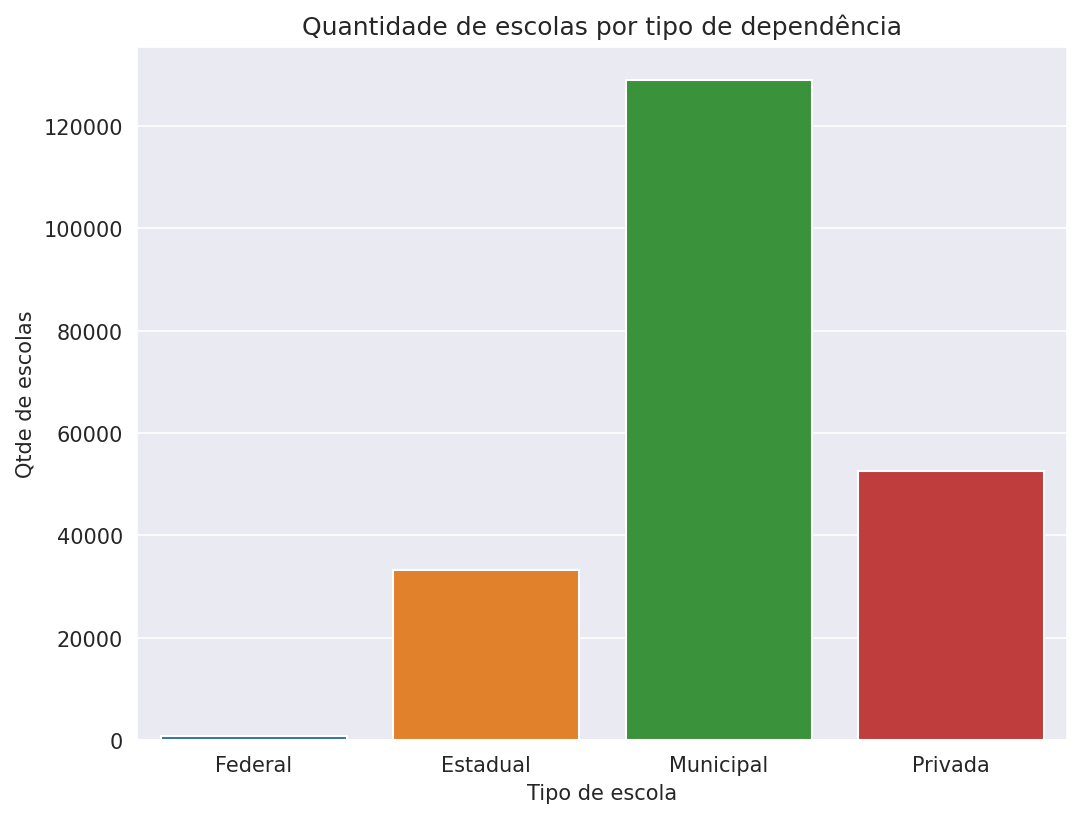

In [ ]:
escolas = df.groupby('TP_DEPENDENCIA')['NO_ENTIDADE'].count().rename('Qtde de escolas').reset_index()
escolas['Tipo de escola'] = escolas['TP_DEPENDENCIA'].map({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})
escolas

sns.set_style('darkgrid')
plt.figure(figsize=(8,6), dpi=150)
sns.barplot(escolas,
            x='Tipo de escola',
            y='Qtde de escolas',
            hue='Tipo de escola')

plt.title('Quantidade de escolas por tipo de dependência')
# plt.savefig("Quantidade_escolas_dependencia.png", dpi=300)
plt.show()


# Dessa forma, podemos entender que possuimos mais de 120.000 escolas municipais em nosso dataset, representando uma parte significativa do nosso conjunto.

# Preparando os datasets

vamos criar datasets diferentes para cada finalidade a ser analisada, que serão as seguintes:


*   infraesturuta
*   funcionarios auxiliares
*   acessibilidade e diversidade
*   participação







# Infraestrutura

Perguntas a serem respondidas:


1.   Como estão os acessos a água potável, energia e saneamento das escolas?
3.   As escolas oferecem suporte adequado para seus alunos?
4.   Os alunos possuem acesso a alimentação adequada?




# 1) Como estão os acessos a água potável, energia e saneamento das escolas?

In [ ]:
#primeiro vamos criar o nosso dataset que ira analisar a infraestutura das escolas
df_infra = df[['NO_ENTIDADE','NO_REGIAO', 'SG_UF', 'TP_DEPENDENCIA', 'TP_LOCALIZACAO', 'TP_LOCALIZACAO_DIFERENCIADA',
               'IN_EXAME_SELECAO', 'IN_ALIMENTACAO', 'IN_AGUA_POTAVEL', 'IN_AGUA_INEXISTENTE', 'IN_ENERGIA_INEXISTENTE',
               'IN_ESGOTO_INEXISTENTE', 'IN_AREA_VERDE','IN_BANHEIRO', 'IN_BANHEIRO_EI', 'IN_BANHEIRO_PNE', 'IN_BANHEIRO_FUNCIONARIOS',
               'IN_LABORATORIO_CIENCIAS', 'IN_LABORATORIO_INFORMATICA', 'IN_LABORATORIO_EDUC_PROF',
               'IN_ACESSIBILIDADE_CORRIMAO', 'IN_ACESSIBILIDADE_ELEVADOR', 'IN_ACESSIBILIDADE_PISOS_TATEIS', 'IN_ACESSIBILIDADE_VAO_LIVRE',
               'IN_ACESSIBILIDADE_RAMPAS', 'IN_ACESSIBILIDADE_INEXISTENTE','QT_SALAS_UTILIZADAS_DENTRO',
               'QT_SALAS_UTILIZADAS_FORA', 'QT_SALAS_UTILIZADAS', 'QT_SALAS_UTILIZA_CLIMATIZADAS', 'QT_SALAS_UTILIZADAS_ACESSIVEIS', 'QT_MAT_ESP_CE']]



In [ ]:
df_infra


,NO_ENTIDADE,NO_REGIAO,SG_UF,TP_DEPENDENCIA,TP_LOCALIZACAO,TP_LOCALIZACAO_DIFERENCIADA,IN_EXAME_SELECAO,IN_ALIMENTACAO,IN_AGUA_POTAVEL,IN_AGUA_INEXISTENTE,...,IN_ACESSIBILIDADE_PISOS_TATEIS,IN_ACESSIBILIDADE_VAO_LIVRE,IN_ACESSIBILIDADE_RAMPAS,IN_ACESSIBILIDADE_INEXISTENTE,QT_SALAS_UTILIZADAS_DENTRO,QT_SALAS_UTILIZADAS_FORA,QT_SALAS_UTILIZADAS,QT_SALAS_UTILIZA_CLIMATIZADAS,QT_SALAS_UTILIZADAS_ACESSIVEIS,QT_MAT_ESP_CE
0,EIEEF HAP BITT TUPARI,Norte,RO,2,2,2,0,1,1,0,...,0,0,0,1,1,0,1,0,0,0
1,CEEJA LUIZ VAZ DE CAMOES,Norte,RO,2,1,0,0,1,1,0,...,1,1,0,0,9,4,13,13,13,0
2,EMMEF 7 DE SETEMBRO,Norte,RO,3,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,EMEIEF BOA ESPERANCA,Norte,RO,3,2,0,0,1,1,0,...,0,0,0,1,9,0,9,7,0,0
4,EEEFM EURIDICE LOPES PEDROSO,Norte,RO,2,1,0,0,1,1,0,...,1,1,1,0,9,24,33,9,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215540,ESC PEQUENO ENCANTO,Centro-Oeste,DF,4,1,0,0,0,1,0,...,1,1,1,0,15,0,15,12,12,0
215541,SOCIEDADE ANCHIETA DE EDUCACAO INTEGRAL LTDA,Centro-Oeste,DF,4,1,0,1,0,1,0,...,1,0,0,0,50,0,50,8,0,0
215542,COL MAPA,Centro-Oeste,DF,4,1,0,0,0,1,0,...,1,0,1,0,16,0,16,0,16,0
215543,COBIAN - COL BIANGULO,Centro-Oeste,DF,4,1,0,0,1,1,0,...,0,1,1,0,20,0,20,2,20,0


/tmp/ipython-input-11-1199106393.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_infra_basica,


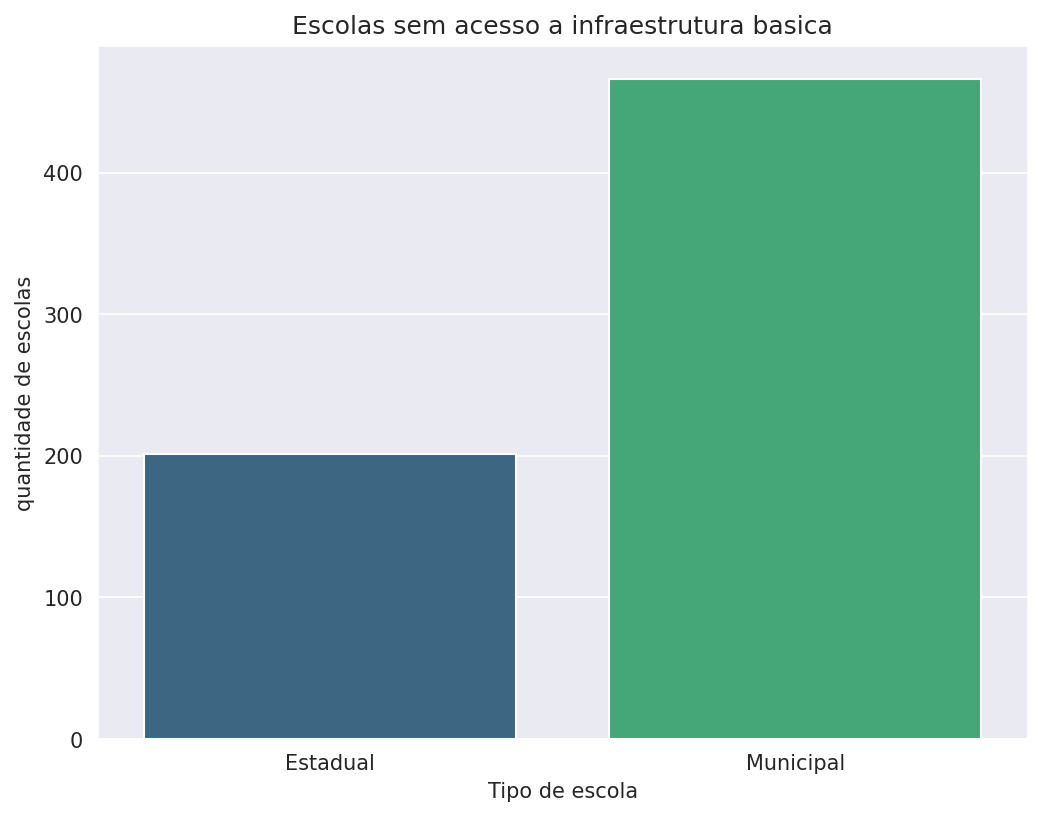

In [ ]:
#vamos analisar como são os casos de água potável, energia e saneamento nas escolas.
#que a localização e esses tres aspectos, o estado que possui mais desses tres inexistentes,

df_infra_basica = df_infra[['IN_AGUA_POTAVEL', 'IN_ENERGIA_INEXISTENTE', 'IN_ESGOTO_INEXISTENTE', 'TP_DEPENDENCIA']]

#vamos montar o df com as escolas que nao possuem: agua potavel, energia e esgoto.


#vamos fazer uma query para que somente as escolas que nao possuem agua potavel, sem energia e esgoto sejam selecionadas
df_infra_basica = df_infra_basica.query('(IN_AGUA_POTAVEL == 0) and (IN_ENERGIA_INEXISTENTE == 1) and (IN_ESGOTO_INEXISTENTE == 1)')
df_infra_basica['Tipo de escola'] = df_infra_basica['TP_DEPENDENCIA'].map({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})

#vamos demonstar em como está distribuido as escolas sem infraestrutura basica:

contagem = df_infra_basica['Tipo de escola'].value_counts()


plt.figure(figsize=(8,6), dpi=150)

sns.set_style('darkgrid')

sns.countplot(df_infra_basica,
              x='Tipo de escola',
              palette='viridis')


plt.title('Escolas sem acesso a infraestrutura basica')
plt.ylabel('quantidade de escolas')
# plt.savefig('Escolas_sem_infra_basica.png', dpi=300, bbox_inches="tight")
plt.show()




# podemos ver que existem muitas escolas municipais carecem  mais de infraestrura basica que escolas estaduais

# 2) As escolas oferecem suporte adequado para seus alunos?

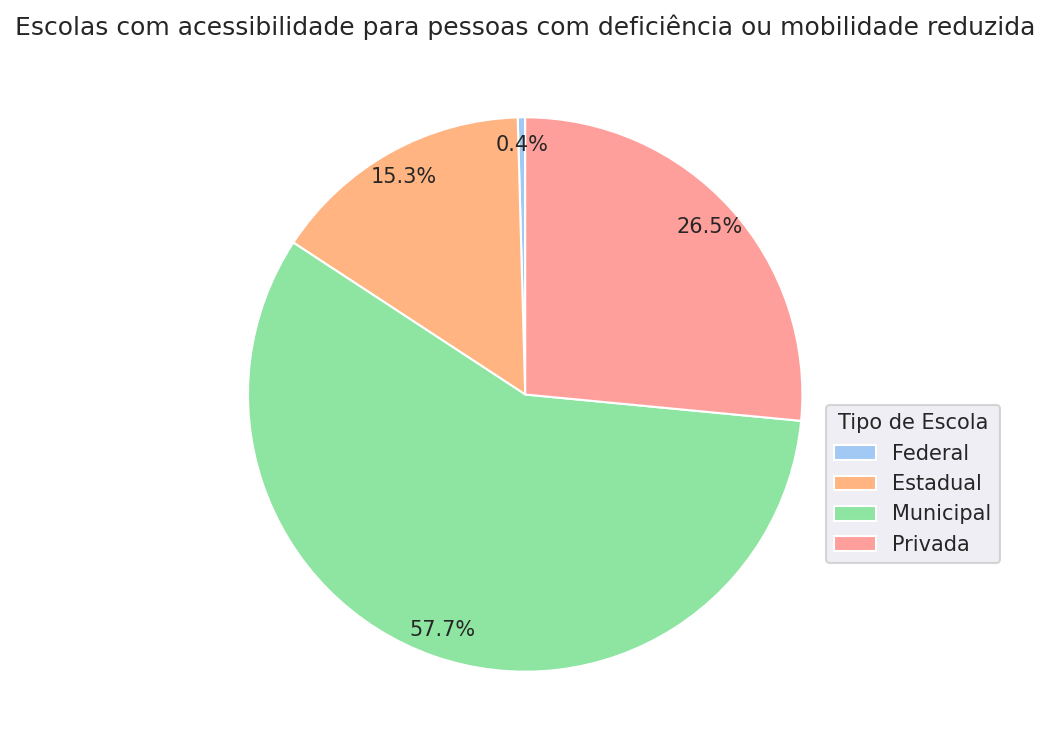

In [ ]:
#agora vamos analisar as instalações  das escolas e se elas possuem banheiros adequados para educação infantil e pessoas com deficiencia ou mobilidade reduzida.

df_infra.columns

df_acessibilidade = df_infra[['NO_REGIAO', 'SG_UF', 'TP_DEPENDENCIA', 'IN_BANHEIRO_EI', 'IN_BANHEIRO_PNE', 'IN_ACESSIBILIDADE_CORRIMAO', 'IN_ACESSIBILIDADE_ELEVADOR',
                              'IN_ACESSIBILIDADE_PISOS_TATEIS', 'IN_ACESSIBILIDADE_VAO_LIVRE', 'IN_ACESSIBILIDADE_RAMPAS', 'IN_ACESSIBILIDADE_INEXISTENTE', 'QT_SALAS_UTILIZADAS_ACESSIVEIS',
                              'QT_MAT_ESP_CE']]

#primeiro vamos começar analisando qual tipo de escola possui maior acessibilidade

df_apresenta_acessibilidade = df_acessibilidade[df_acessibilidade['IN_ACESSIBILIDADE_INEXISTENTE'] == 0].groupby('TP_DEPENDENCIA').size().rename('Escolas com acessibilidade')
df_apresenta_acessibilidade = df_apresenta_acessibilidade.reset_index()

df_apresenta_acessibilidade['Tipo de escola'] = df_apresenta_acessibilidade['TP_DEPENDENCIA'].map({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})

plt.figure(figsize=(8,6), dpi=150)

plt.pie(df_apresenta_acessibilidade['Escolas com acessibilidade'],
            autopct='%1.1f%%',
            startangle=90,
            colors=sns.color_palette('pastel'),
            pctdistance=0.9
            )
plt.legend(df_apresenta_acessibilidade['Tipo de escola'], title="Tipo de Escola",
           bbox_to_anchor=(1.2, 0.5))

plt.title('Escolas com acessibilidade para pessoas com deficiência ou mobilidade reduzida')
# plt.savefig("acessiblidade_por_dependencia.png", dpi=300)
plt.show()


# As escolas municipais lideram em questão de acessibilidade, representando mais da metade do nosso conjunto. Isso mostra que os municipios têm se esforçado para que a acessibilidade esteja presente em suas escolas.

#Agora vamos analisar quantos alunos que precisam de acessibilidade estão matriculados em escolas



/tmp/ipython-input-13-2767569568.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_alunos_matriculados,


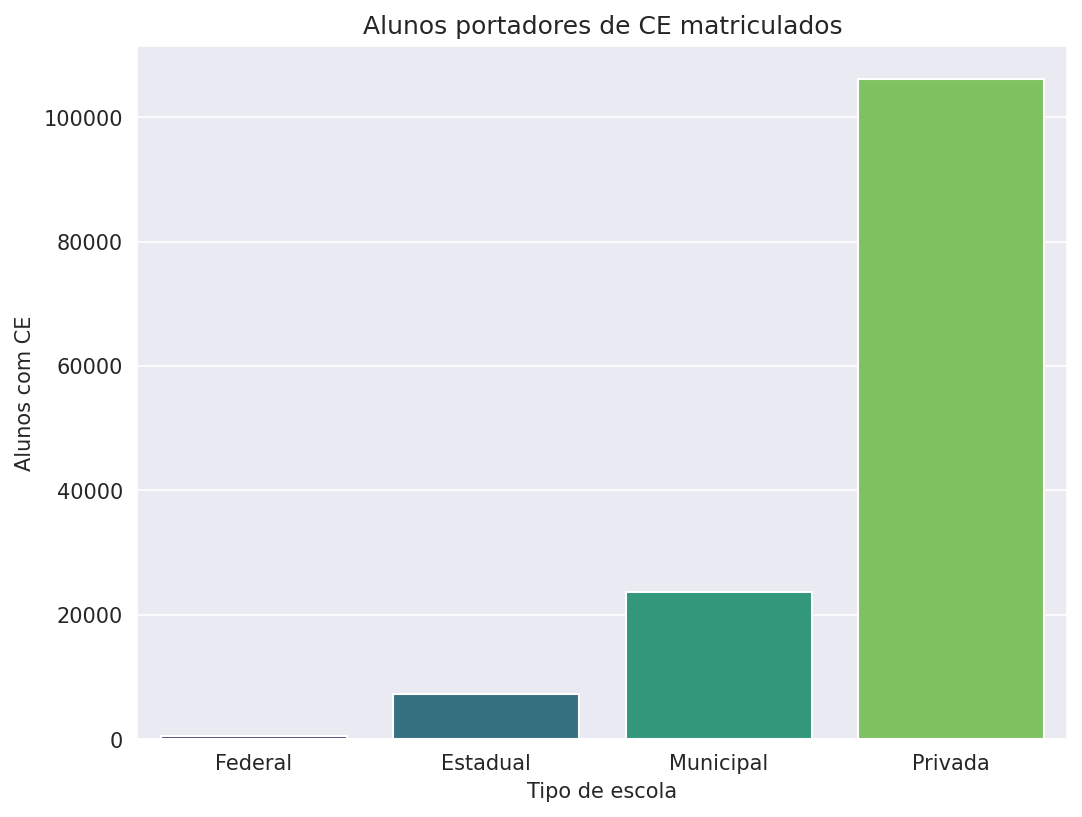

In [ ]:
#vamos montar o df para a analise

df_alunos_matriculados = df_infra[['QT_MAT_ESP_CE', 'TP_DEPENDENCIA', 'IN_ACESSIBILIDADE_INEXISTENTE']]
df_alunos_matriculados = df_alunos_matriculados.query('IN_ACESSIBILIDADE_INEXISTENTE == 0').groupby('TP_DEPENDENCIA').sum()
df_alunos_matriculados = df_alunos_matriculados.reset_index()
df_alunos_matriculados['Tipo de escola'] = df_alunos_matriculados['TP_DEPENDENCIA'].map({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})
df_alunos_matriculados

plt.figure(figsize=(8,6), dpi=150)
sns.barplot(data=df_alunos_matriculados,
            x='Tipo de escola',
            y='QT_MAT_ESP_CE',
            palette='viridis')
plt.ylabel('Alunos com CE')

plt.title('Alunos portadores de CE matriculados')
# plt.savefig("alunos_CE_por_dependencia.png", dpi=300)
plt.show()



# Podemos ver que as escolas particulares, apesar de terem 26.5% de suas dependencias com acessibilidade, são o grupo que mais possui alunos que utilizam a infraestrutura adequada. Isso demonstra que os pais de alunos que possuem alguma condição especial preferem matricular seus filhos em escolas particulares que em escolas municipais, apesar do municipio apresentar escolas com acessibilidade.

# 3)Os alunos possuem acesso ao Programa Nacional de Alimentação Escolar?
vamos analisar quais tipos de escolas estão precarizadas em relação ao Programa Nacional de Alimentação Escolar e quais os estados que possuem o maior numero de escolas sem acesso ao PNAE/FNDE.

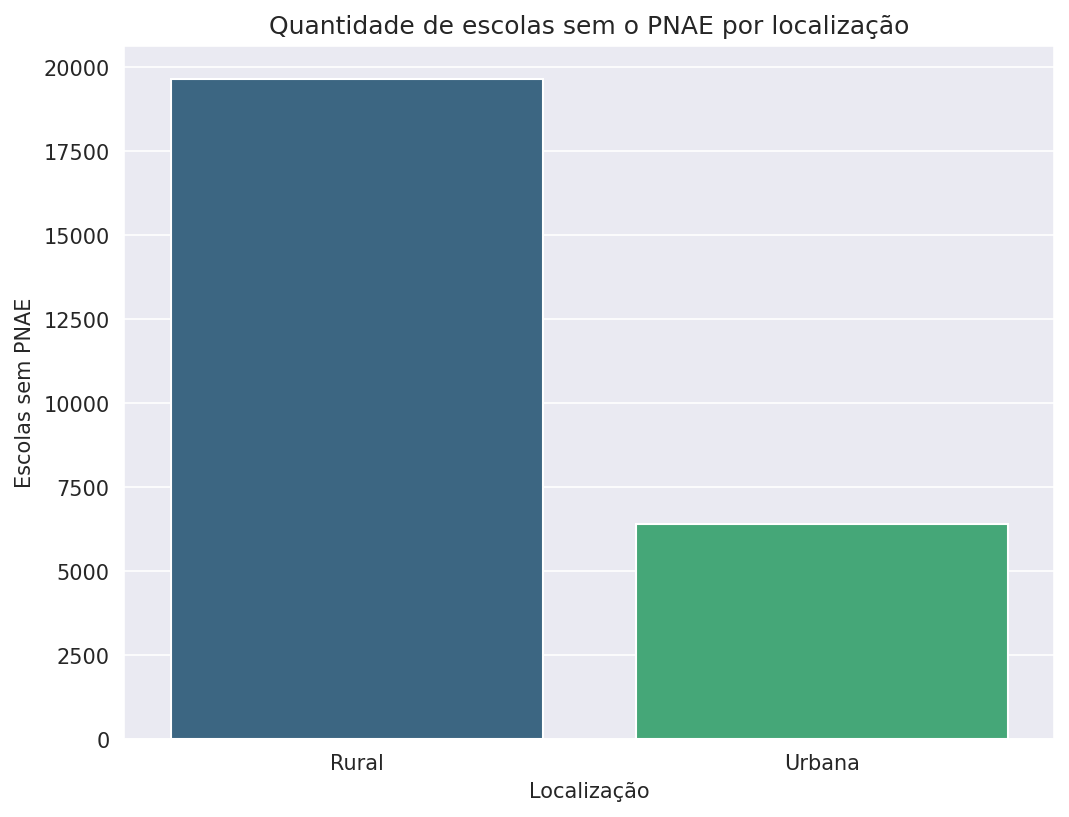

In [ ]:
#vamos criar um df para analisar se as escolas possuem alimentaçao adequada.

df_alimentação = df_infra[['TP_LOCALIZACAO', 'IN_ALIMENTACAO','SG_UF', 'NO_ENTIDADE', 'TP_DEPENDENCIA']]

#como escolas privadas nao possuem PNAE/FNDE e nosso DF não possui muitos registros de escolas federais vamos retirar os dois
df_alimentação = df_alimentação[(df_alimentação['TP_DEPENDENCIA'] != 4) & (df_alimentação['TP_DEPENDENCIA'] != 1) ]
df_alimentação
df_alimentação = df_alimentação.query('IN_ALIMENTACAO == 0')
df_alimentação['Tipo de escola'] =df_alimentação['TP_DEPENDENCIA'].map({1: 'Federal', 2: 'Estadual', 3: 'Municipal'})
df_alimentação['Localização'] = df['TP_LOCALIZACAO'].map({1 : 'Urbana', 2: 'Rural'})
df_alimentação_localização = df_alimentação.groupby('Localização')['IN_ALIMENTACAO'].count().rename('Escolas sem PNAE').reset_index()
df_alimentação_localização


plt.figure(figsize=(8,6), dpi=150)
sns.barplot(data=df_alimentação_localização,
            x='Localização',
            y='Escolas sem PNAE',
            hue='Localização',
            palette='viridis'
            )
plt.title('Quantidade de escolas sem o PNAE por localização')
# plt.savefig("localizacao_sem_pnae.png", dpi=300)
plt.show()


# podemos ver a clara distinção entre as escolas urbanas e rurais em relação  a falta do PNAE.

/tmp/ipython-input-15-3272978445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_representação['Localização'] = df['TP_LOCALIZACAO'].map({1: 'Urbana', 2: 'Rural'})


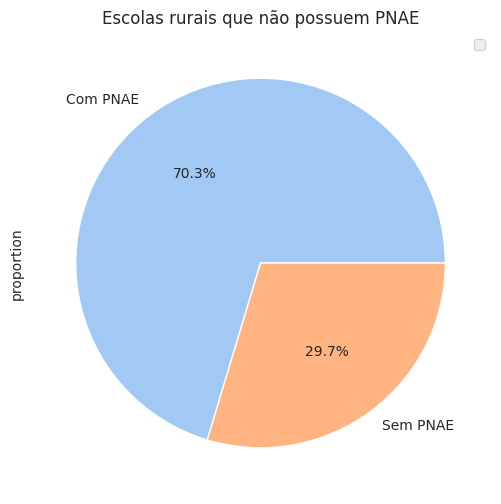

In [ ]:
#vamos fazer um grafico de pizza para demonstar a representação em porcentagem das escolas rurais que não possuem PNAE

df_representação = df[['TP_LOCALIZACAO', 'IN_ALIMENTACAO']]
df_representação['Localização'] = df['TP_LOCALIZACAO'].map({1: 'Urbana', 2: 'Rural'})

contagem = df_representação['IN_ALIMENTACAO'].value_counts(normalize=True) * 100

plt.figure(figsize=(8,6), dpi=100)
contagem.plot.pie(
    labels = ['Sem PNAE' if i == 0 else 'Com PNAE' for i in contagem.index],
    autopct='%1.1f%%',
    colors= sns.color_palette('pastel')
)


plt.legend('')
plt.title('Escolas rurais que não possuem PNAE')
# plt.savefig("escolas_rurais_sem_pnae.png", dpi=300)
plt.show()






#Apesar de existirem muitas escolas rurais sem PNAE comparada as escolas urbanas, cerca de 84% destas possuem o Programa Nacional de Alimentação Escolar

/tmp/ipython-input-16-2331654316.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(brasil_tipo.geometry.centroid.x,
/tmp/ipython-input-16-2331654316.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  brasil_tipo.geometry.centroid.y,


<Figure size 1200x900 with 0 Axes>

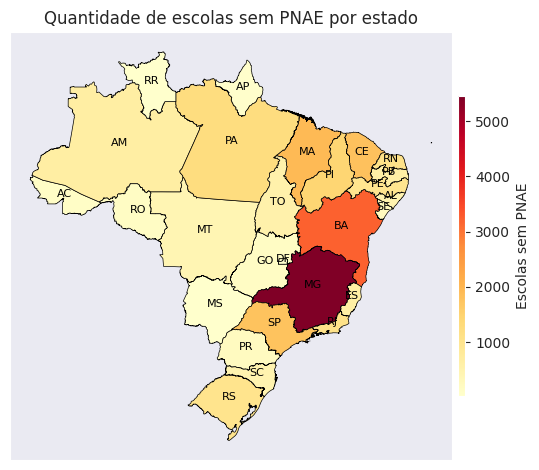

In [ ]:
#quantidade de escolas que não possuem o PNAE por estado
df_alimentação_estado = df_alimentação.groupby('SG_UF')['IN_ALIMENTACAO'].count().rename('Escolas sem PNAE').reset_index()

brasil_tipo = brasil.merge(df_alimentação_estado,
                           left_on='sigla',
                           right_on='SG_UF',
                           how='left'
)

plt.figure(figsize=(8,6), dpi=150)
ax = brasil_tipo.plot(
            column='Escolas sem PNAE',
            cmap='YlOrRd',
            legend=True,
            edgecolor='black',
            linewidth=0.5,
            missing_kwds={'color': 'lightgrey'},
            legend_kwds={
                'label': 'Escolas sem PNAE',
                'shrink': 0.7,
                'orientation': 'vertical',
                'pad': 0.01,
                'aspect': 40
            }
        )

for x, y, label in zip(brasil_tipo.geometry.centroid.x,
                       brasil_tipo.geometry.centroid.y,
                       brasil_tipo['sigla']):
  ax.text(x, y, label, fontsize=8, ha='center', color='black')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.title('Quantidade de escolas sem PNAE por estado')
plt.tight_layout()

# plt.savefig("escolas_sem_pnae_estado.png", dpi=300)
plt.show()






# Podemos ver que o eixo de São Paulo até Bahia possui uma quantidade considerável de escolas sem o PNAE, mas o estado que mais se destaca é o estado de Minas Gerais, com cerca de 5mil escolas sem o Programa Nacional de Alimentação Escolar

# funcionarios auxiliares
vamos analisar o quadro de funcionarios que apoiam nas escolas como psicologas, assistentes sociais, cozinheiras, merendeiras e revisores de braile

In [ ]:
df.columns

Index(['NU_ANO_CENSO', 'NO_REGIAO', 'CO_REGIAO', 'NO_UF', 'SG_UF', 'CO_UF',
       'NO_MUNICIPIO', 'CO_MUNICIPIO', 'NO_REGIAO_GEOG_INTERM',
       'CO_REGIAO_GEOG_INTERM',
       ...
       'QT_TUR_BAS_D', 'QT_TUR_BAS_N', 'QT_TUR_BAS_EAD', 'QT_TUR_INF_INT',
       'QT_TUR_INF_CRE_INT', 'QT_TUR_INF_PRE_INT', 'QT_TUR_FUND_INT',
       'QT_TUR_FUND_AI_INT', 'QT_TUR_FUND_AF_INT', 'QT_TUR_MED_INT'],
      dtype='object', length=426)

In [ ]:
df_profissionais = df[['NO_ENTIDADE','NO_REGIAO', 'SG_UF', 'TP_DEPENDENCIA', 'TP_LOCALIZACAO', 'TP_LOCALIZACAO_DIFERENCIADA',
               'IN_EXAME_SELECAO', 'IN_AGUA_POTAVEL', 'IN_ENERGIA_INEXISTENTE', 'IN_ESGOTO_INEXISTENTE', 'IN_PROF_SERVICOS_GERAIS', 'IN_PROF_PSICOLOGO', 'IN_PROF_ALIMENTACAO', 'IN_PROF_ASSIST_SOCIAL', 'IN_PROF_TRAD_LIBRAS',
                    'IN_PROF_REVISOR_BRAILLE',]]
df_profissionais['Tipo de escola'] = df_profissionais['TP_DEPENDENCIA'].map({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})

df['Tipo de escola'] = df['TP_DEPENDENCIA'].map({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})



/tmp/ipython-input-18-2664059770.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_profissionais['Tipo de escola'] = df_profissionais['TP_DEPENDENCIA'].map({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})
/tmp/ipython-input-18-2664059770.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Tipo de escola'] = df['TP_DEPENDENCIA'].map({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})


# Como está relacionado os profissionais que auxiliam nas escolas?

# Como estão distribuitos os profissionais entre as escolas:

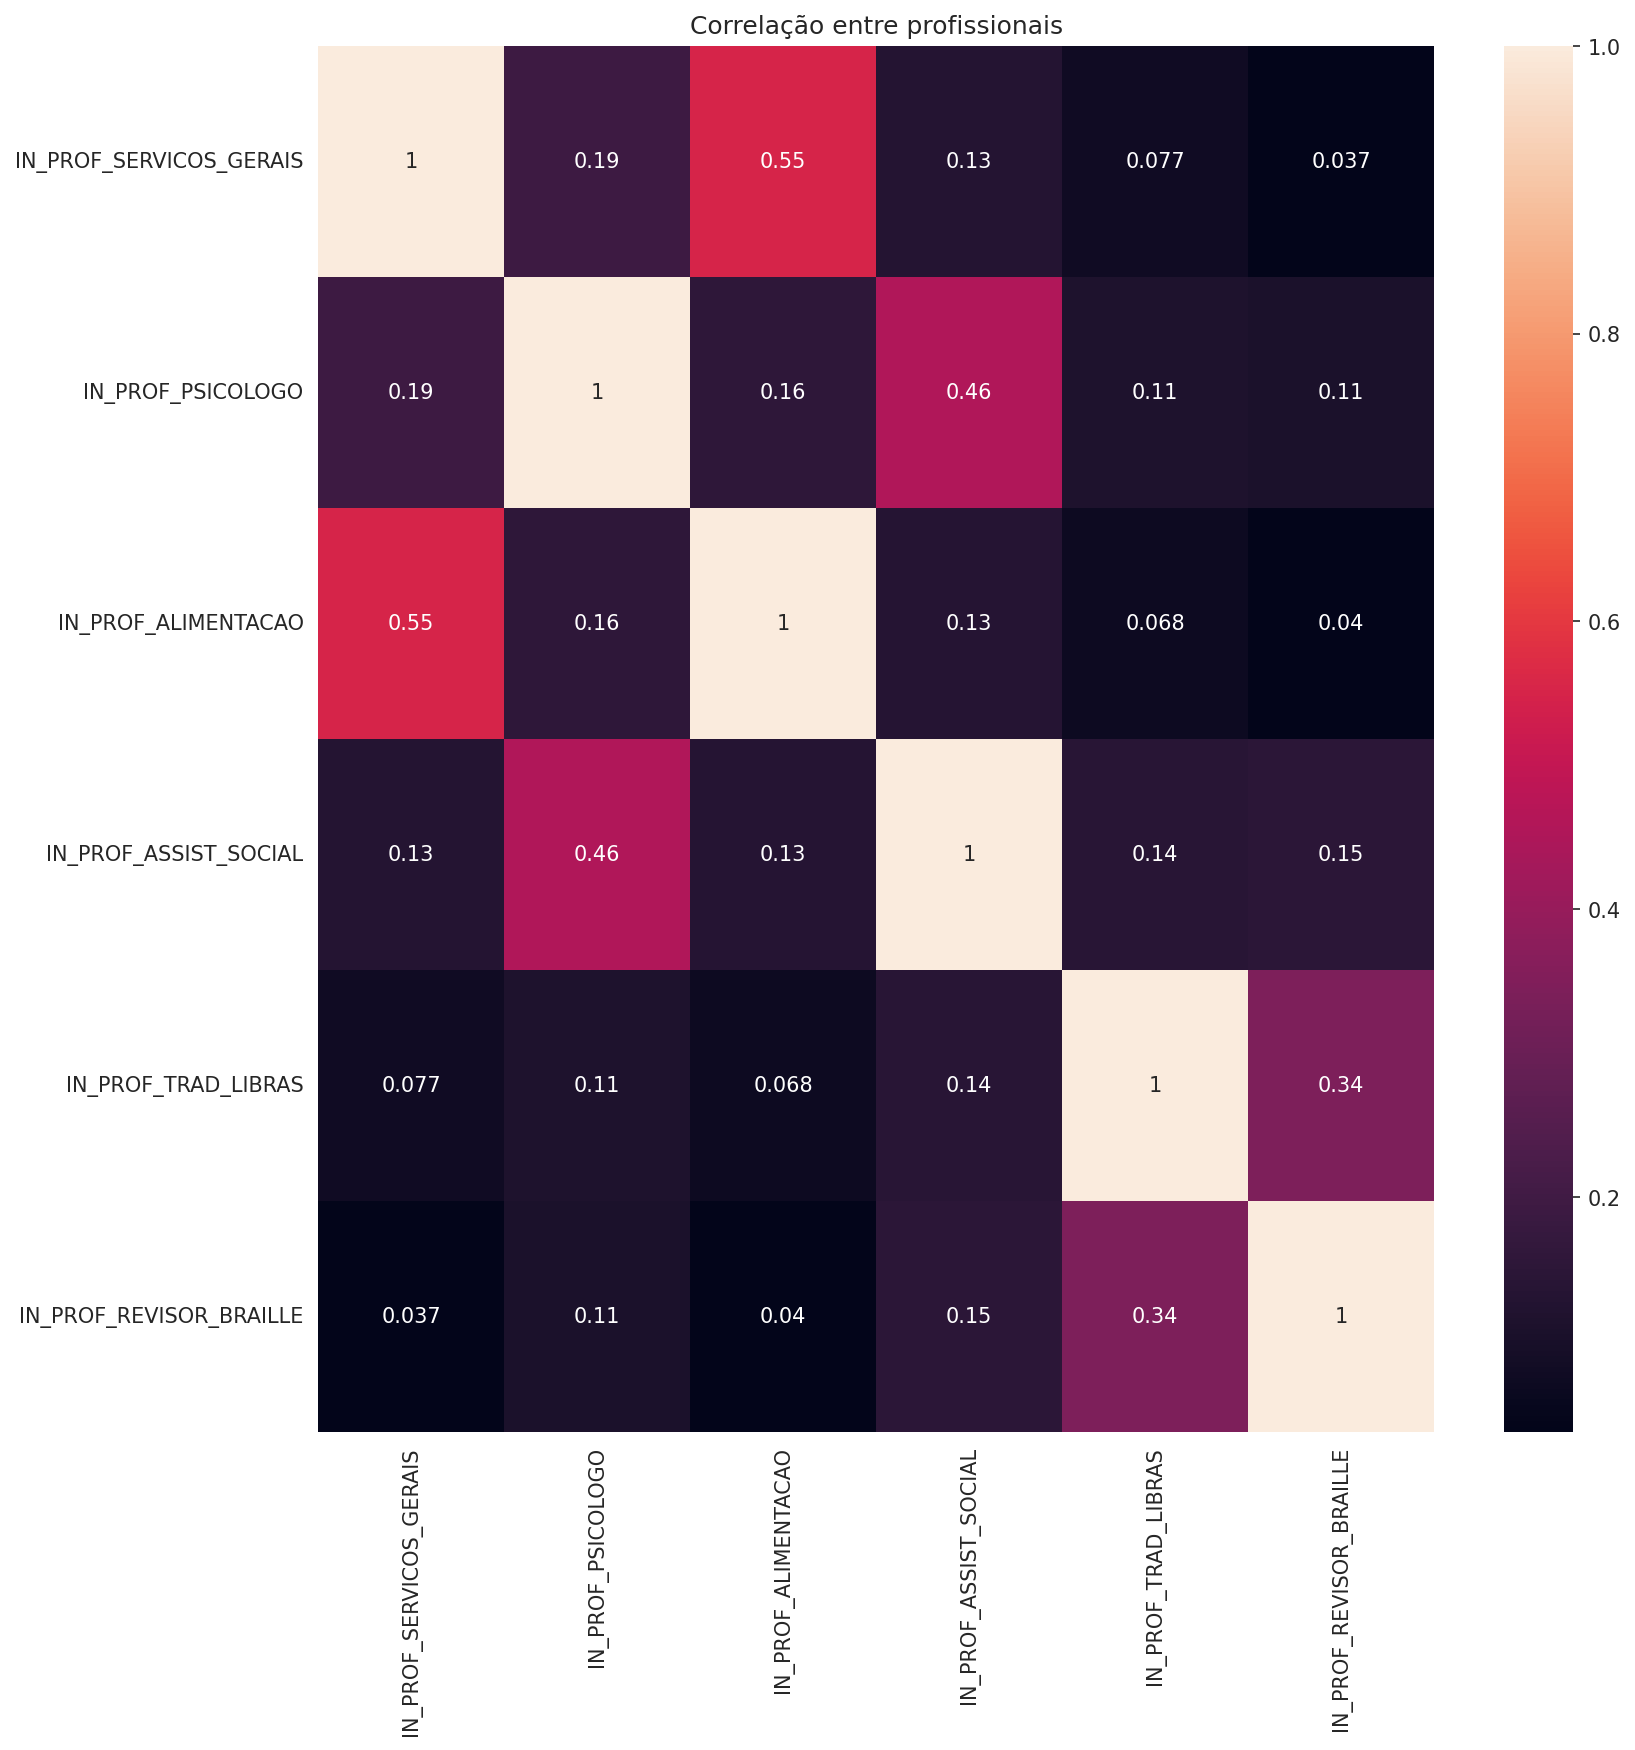

In [ ]:
profissionais = ['IN_PROF_SERVICOS_GERAIS', 'IN_PROF_PSICOLOGO', 'IN_PROF_ALIMENTACAO', 'IN_PROF_ASSIST_SOCIAL', 'IN_PROF_TRAD_LIBRAS',
                  'IN_PROF_REVISOR_BRAILLE']

matriz_correlacao = df_profissionais[profissionais].corr()
plt.figure(figsize=(12,12),dpi=150)
sns.heatmap(matriz_correlacao, annot=True, cmap='rocket')
plt.title('Correlação entre profissionais')
# plt.savefig("correlacao_profissionais.png", dpi=300, bbox_inches="tight")
plt.show()

#podemos ver que os profissionais de alimentaçao tem  alta correlação com serviços gerais, e também vale destacar a correlação entre psicologos e assistentes sociais, demonstrando que o trabalho de ambos há uma relação muito próxima.

In [ ]:
def plot_profissional(profissional, nome, cmap='YlOrRd'):
    '''essa função cria subplots para cada tipo de escola para o profissional
    selecionado no argumento da função'''
    # Filtrar e agrupar dados
    df_filtrado = df[df[profissional] == 1]
    qtd = df_filtrado.groupby(['SG_UF', 'Tipo de escola']).size().reset_index(name='Quantidade')

    # Preparar subplots
    tipos_escola = qtd['Tipo de escola'].unique()
    fig, axes = plt.subplots(1, len(tipos_escola), figsize=(18, 6))

    for ax, tipo in zip(axes, tipos_escola):
      #fazendo um loop e criando um dataframe para cada tipo de escola
        df_tipo = qtd[qtd['Tipo de escola'] == tipo]

        brasil_tipo = brasil.merge(
            df_tipo,
            left_on='sigla',
            right_on='SG_UF',
            how='left'
        )

        brasil_tipo.plot(
            column='Quantidade',
            cmap=cmap,
            legend=True,
            edgecolor='black',
            linewidth=0.5,
            missing_kwds={'color': 'lightgrey'},
            ax=ax
        )

        for x, y, label in zip(brasil_tipo.geometry.centroid.x,
                               brasil_tipo.geometry.centroid.y,
                               brasil_tipo['sigla']):
            ax.text(x, y, label, fontsize=8, ha='center')

        ax.set_title(f'{nome} - {tipo}')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f"{profissional}.png", dpi=300,  bbox_inches="tight")
    plt.show()

# Assistente social

/tmp/ipython-input-20-176563587.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(brasil_tipo.geometry.centroid.x,
/tmp/ipython-input-20-176563587.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  brasil_tipo.geometry.centroid.y,
/tmp/ipython-input-20-176563587.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(brasil_tipo.geometry.centroid.x,
/tmp/ipython-input-20-176563587.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometr

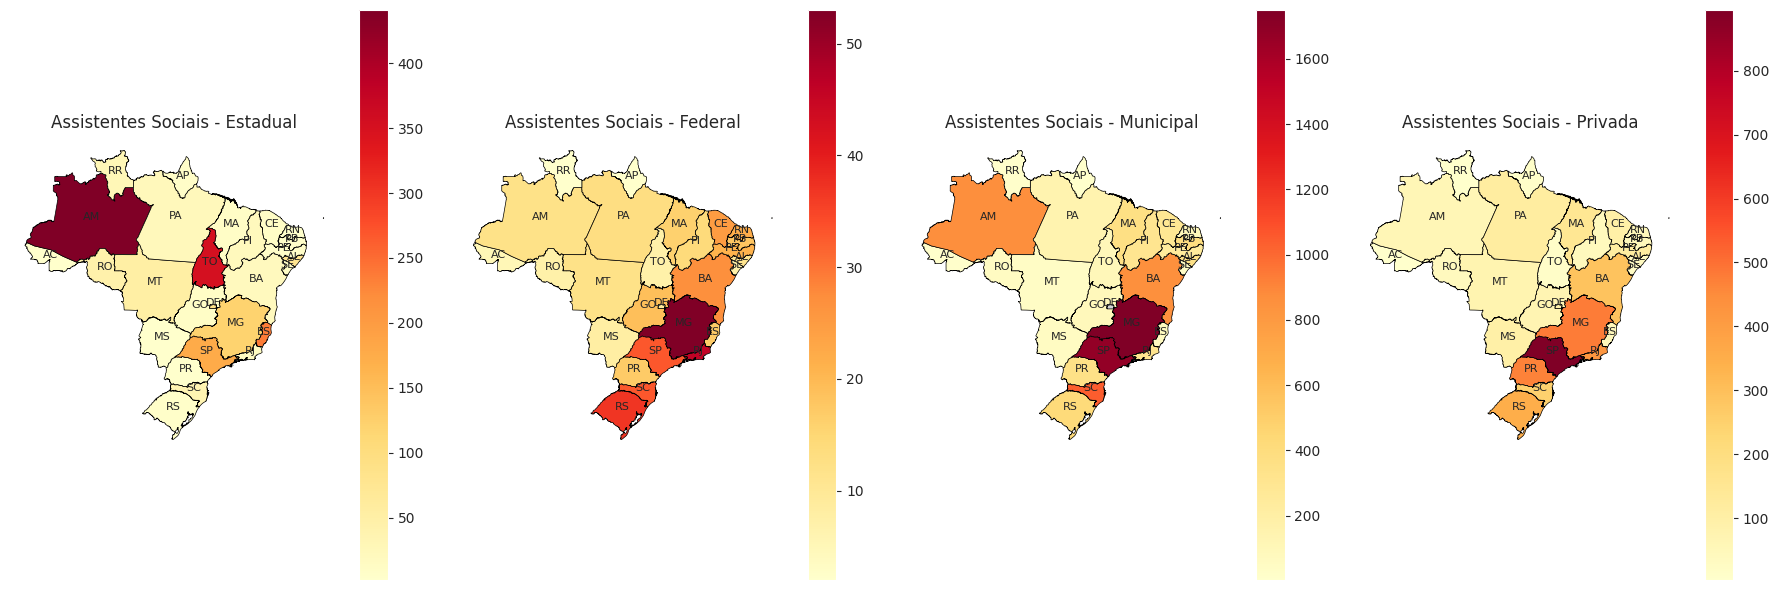

In [ ]:
plot_profissional('IN_PROF_ASSIST_SOCIAL', 'Assistentes Sociais', 'YlOrRd')

# Psicologos

/tmp/ipython-input-20-176563587.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(brasil_tipo.geometry.centroid.x,
/tmp/ipython-input-20-176563587.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  brasil_tipo.geometry.centroid.y,
/tmp/ipython-input-20-176563587.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(brasil_tipo.geometry.centroid.x,
/tmp/ipython-input-20-176563587.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometr

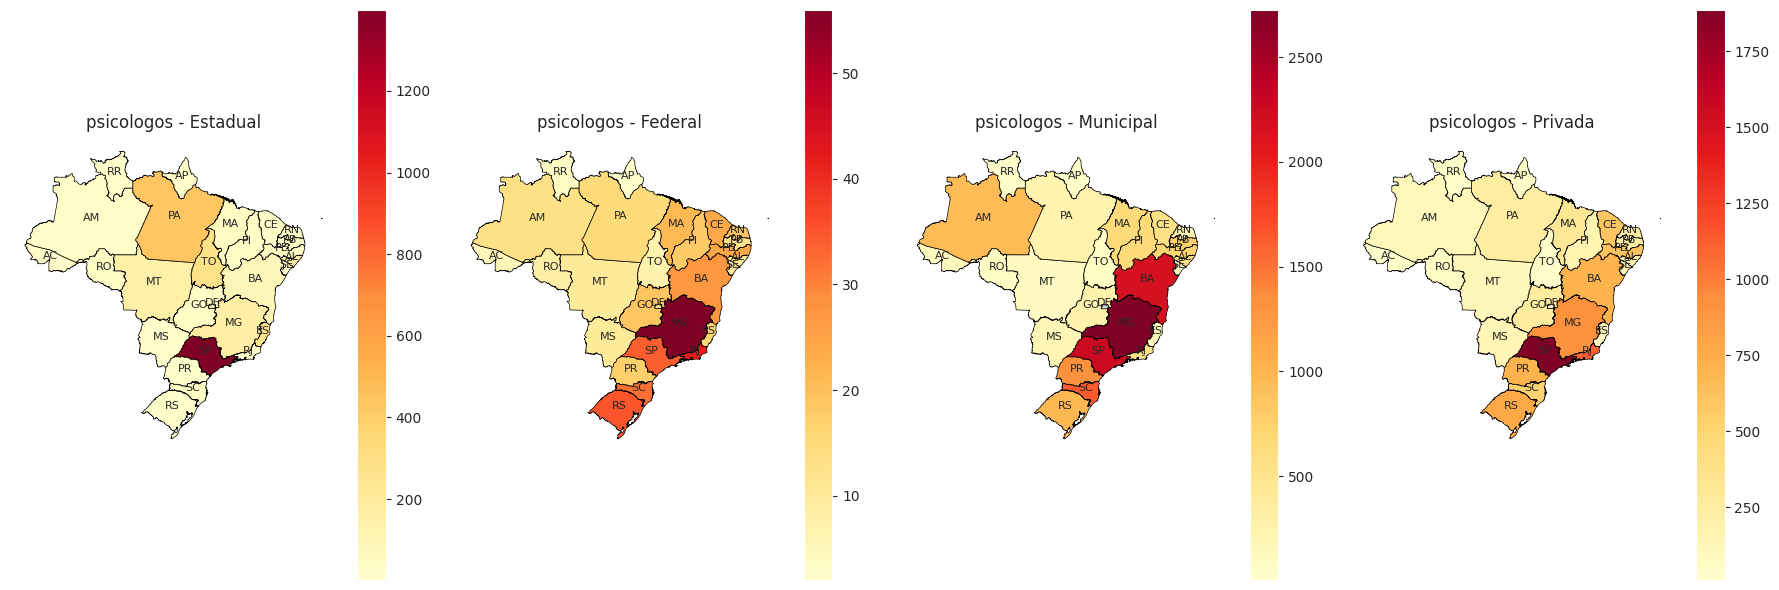

In [ ]:
plot_profissional('IN_PROF_PSICOLOGO', 'psicologos', 'YlOrRd')

/tmp/ipython-input-20-176563587.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(brasil_tipo.geometry.centroid.x,
/tmp/ipython-input-20-176563587.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  brasil_tipo.geometry.centroid.y,
/tmp/ipython-input-20-176563587.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(brasil_tipo.geometry.centroid.x,
/tmp/ipython-input-20-176563587.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometr

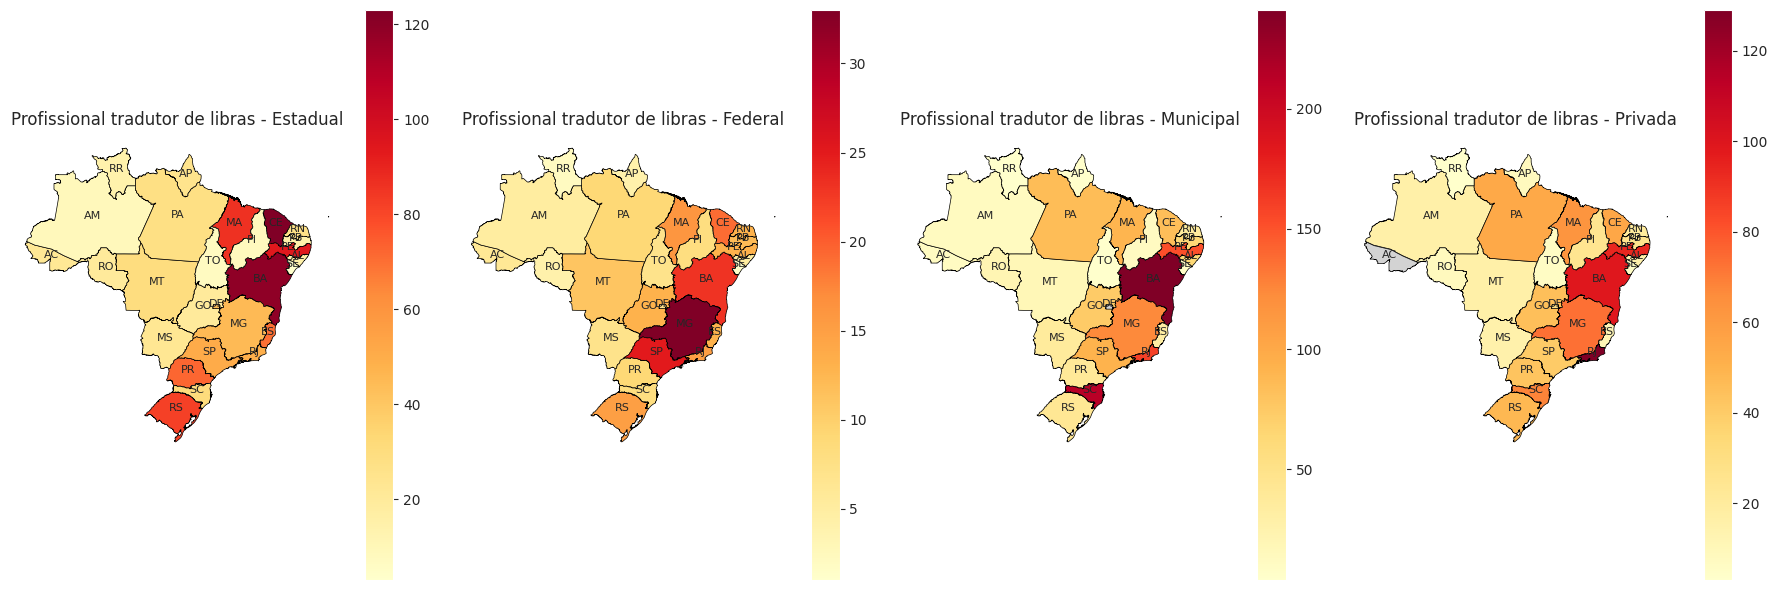

In [ ]:
plot_profissional('IN_PROF_TRAD_LIBRAS', 'Profissional tradutor de libras', 'YlOrRd')

/tmp/ipython-input-20-176563587.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(brasil_tipo.geometry.centroid.x,
/tmp/ipython-input-20-176563587.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  brasil_tipo.geometry.centroid.y,
/tmp/ipython-input-20-176563587.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(brasil_tipo.geometry.centroid.x,
/tmp/ipython-input-20-176563587.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometr

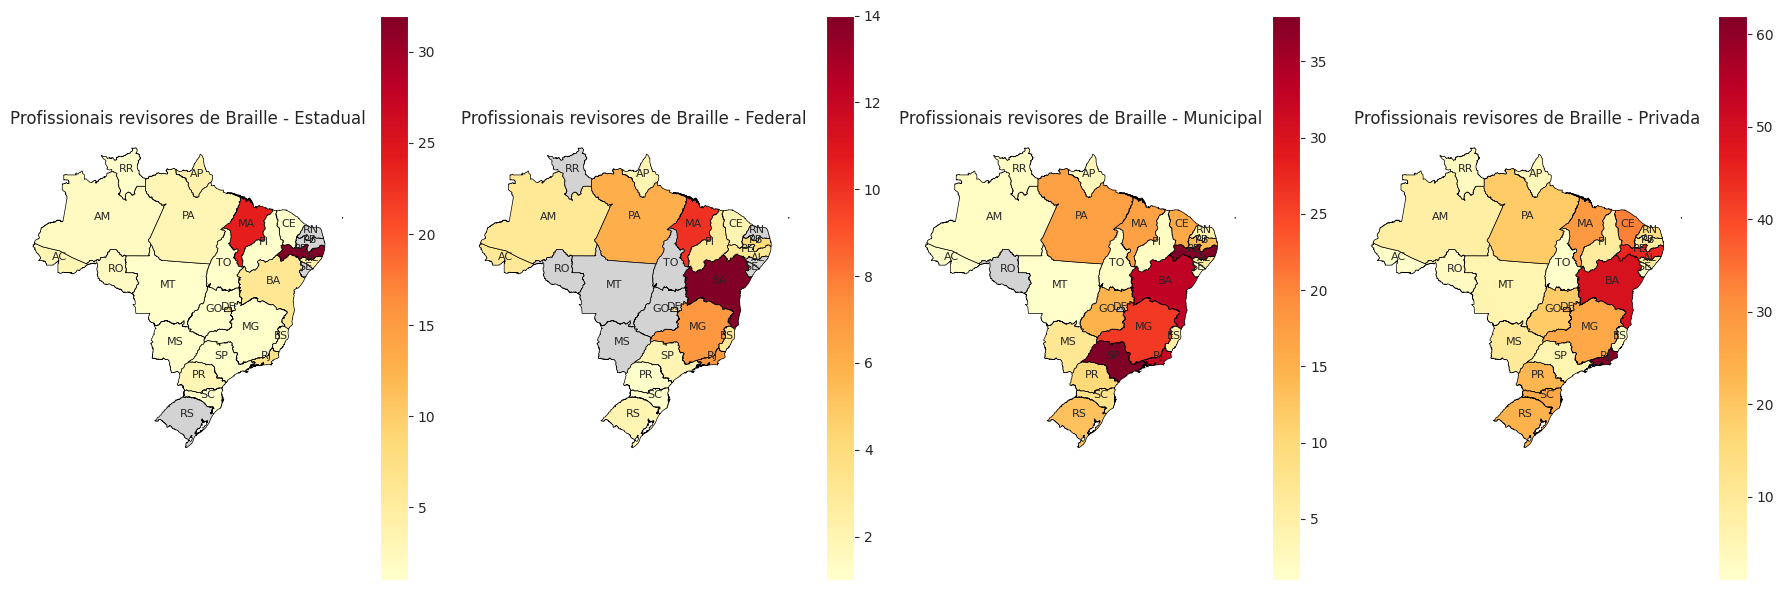

In [ ]:
plot_profissional('IN_PROF_REVISOR_BRAILLE', 'Profissionais revisores de Braille', 'YlOrRd')

# para destacar a negligencia vamos demonstrar quantos alunos estão matriculados em entidades de educação inclusiva

/tmp/ipython-input-25-3429149342.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inclusiva['Tipo de escola'] = df['TP_DEPENDENCIA'].map({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})
/tmp/ipython-input-20-176563587.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(brasil_tipo.geometry.centroid.x,
/tmp/ipython-input-20-176563587.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  brasil_tipo.geometry.centroid.y,
/tmp/ipytho

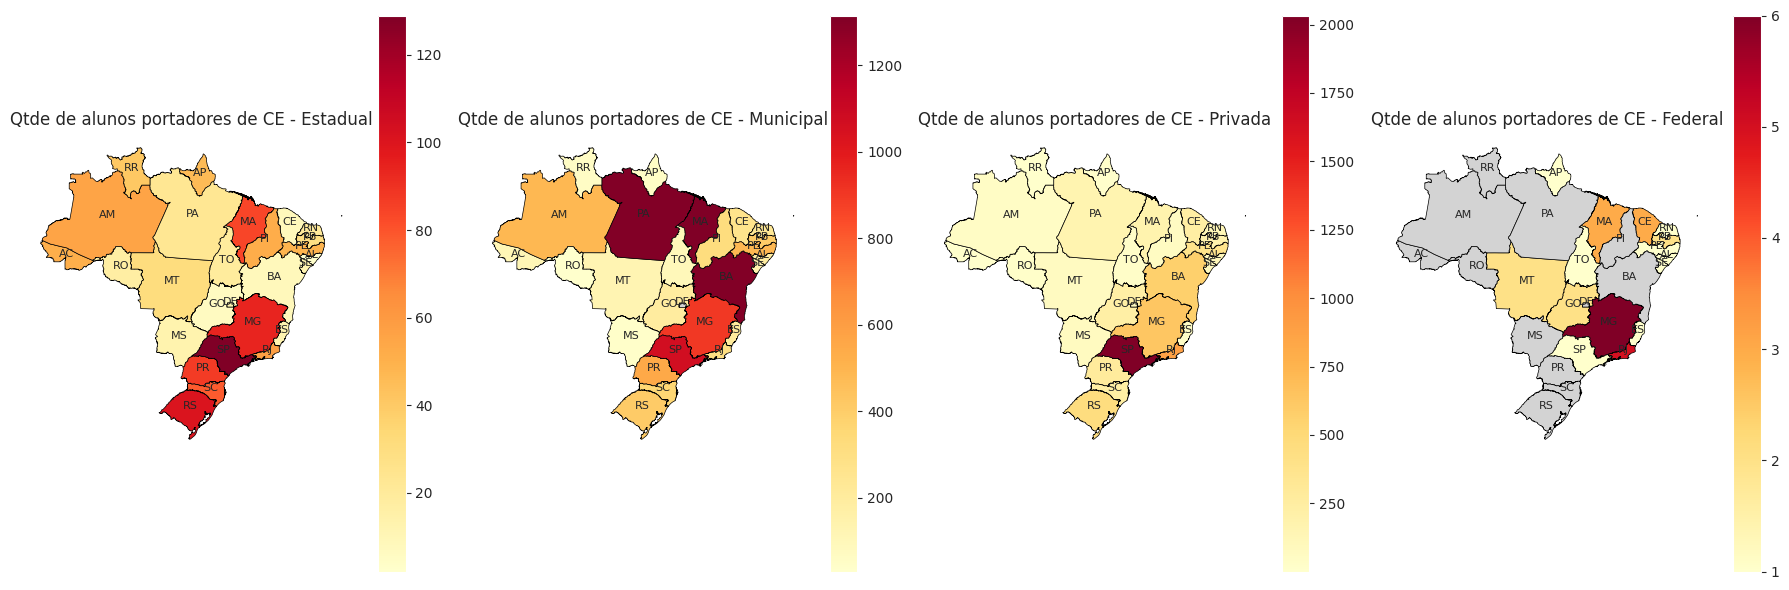

In [ ]:
#vamos montar um df com as variaveis que nos interessam para ficar mais facil e objetivo de manipular
df_inclusiva = df[['QT_MAT_ESP_CC', 'SG_UF', 'TP_DEPENDENCIA']]

df_inclusiva['Tipo de escola'] = df['TP_DEPENDENCIA'].map({1: 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})

df_inclusiva = df_inclusiva.groupby(['SG_UF', 'Tipo de escola'])['QT_MAT_ESP_CC'].sum()
df_inclusiva

plot_profissional('QT_MAT_ESP_CC','Qtde de alunos portadores de CE', 'YlOrRd')

# 3) Agora na parte final da nossa analise vamos voltar o olhar à participação dos alunos nas escolas.

In [8]:
#primeiramente vamos criar o data frame com as colunas que iremos trabalhar

df_participação = df[['CO_MUNICIPIO','QT_MAT_BAS', 'QT_MAT_ESP_CC', 'QT_MAT_BAS_FEM', 'QT_MAT_BAS_MASC', 'QT_MAT_BAS_BRANCA', 'QT_MAT_BAS_PRETA', 'QT_MAT_BAS_PARDA', 'QT_MAT_BAS_AMARELA', 'QT_MAT_BAS_INDIGENA',
                      'QT_MAT_BAS_18_MAIS', 'QT_MAT_BAS_D', 'QT_DOC_MED','QT_MAT_BAS_N', 'QT_MAT_FUND_INT', 'QT_MAT_MED_INT', 'QT_TRANSP_PUBLICO','QT_DOC_BAS', 'QT_DOC_FUND', 'SG_UF', 'TP_DEPENDENCIA', 'TP_LOCALIZACAO']]



# Vamos procurar entender como está a equidade racial entre as escolas

In [ ]:
#vamos criar um grafico de dispersão para demonstra a quantitade da população negra e branca por gênero e por tipo de escola

df_proporção = df_participação.assign(
    total_matriculas = lambda x: x['QT_MAT_BAS'],
    proporção_branca = lambda x: x['QT_MAT_BAS_BRANCA'] / x['total_matriculas'],
    proporção_negra = lambda x: (x['QT_MAT_BAS_PRETA'] + x['QT_MAT_BAS_PARDA']) / x['total_matriculas'],
    proporção_fem = lambda x: x['QT_MAT_BAS_FEM'] / x['total_matriculas']
)

#agora vamos agregar nossas proporções por UF e por tipo
df_agregado = df_proporção.groupby(['SG_UF', 'TP_DEPENDENCIA'])[['proporção_branca', 'proporção_negra', 'proporção_fem']].mean().reset_index()
#vamos mapear o tipo de escola para ficar mais facil de entender no grafico do que apenas 1,2,3,4
df_agregado['Tipo de escola'] = df_agregado['TP_DEPENDENCIA'].map({1 : 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})

fig = px.scatter(
    df_agregado,
    x='proporção_branca',
    y='proporção_negra',
    size='proporção_fem',
    color='Tipo de escola',
    hover_name='SG_UF',
    facet_col='Tipo de escola',
    title='Composição Racial Feminina por Tipo de Escola'

)

fig.update_layout(yaxis_title='Proporção Negra (Preta + Parda)',
                  xaxis_title='Proporção Branca',
                  hovermode='closest')
fig.write_image("composição_racial_femina.png", width=1444, height=720, scale=3)
fig.write_html("composição_racial_feminina_interativa.html")
fig.show()

In [ ]:
#vamos criar um grafico de dispersão para demonstra a quantitade da população negra e branca por gênero e por tipo de escola

df_proporção = df_participação.assign(
    total_matriculas = lambda x: x['QT_MAT_BAS'],
    proporção_branca = lambda x: x['QT_MAT_BAS_BRANCA'] / x['total_matriculas'],
    proporção_negra = lambda x: (x['QT_MAT_BAS_PRETA'] + x['QT_MAT_BAS_PARDA']) / x['total_matriculas'],
    proporção_masc = lambda x: x['QT_MAT_BAS_MASC'] / x['total_matriculas']
)

#agora vamos agregar nossas proporções por UF e por tipo
df_agregado = df_proporção.groupby(['SG_UF', 'TP_DEPENDENCIA'])[['proporção_branca', 'proporção_negra', 'proporção_masc']].mean().reset_index()
#vamos mapear o tipo de escola para ficar mais facil de entender no grafico do que apenas 1,2,3,4
df_agregado['Tipo de escola'] = df_agregado['TP_DEPENDENCIA'].map({1 : 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})

fig = px.scatter(
    df_agregado,
    x='proporção_branca',
    y='proporção_negra',
    size='proporção_masc',
    color='Tipo de escola',
    hover_name='SG_UF',
    facet_col='Tipo de escola',
    title='Composição Racial Masculina por Tipo de Escola'

)

fig.update_layout(yaxis_title='Proporção Negra (Preta + Parda)',
                  xaxis_title='Proporção Branca',
                  hovermode='closest')
fig.write_image("composição_racial_masuculina.png", width=1444, height=720, scale=3)  # Formato PNG
fig.write_html("composição_racial_masculina_interativa.html")
fig.show()

# vamos fazer algumas analises para entender como é o descolamentos dos alunos

/tmp/ipython-input-26-487436535.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-26-487436535.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



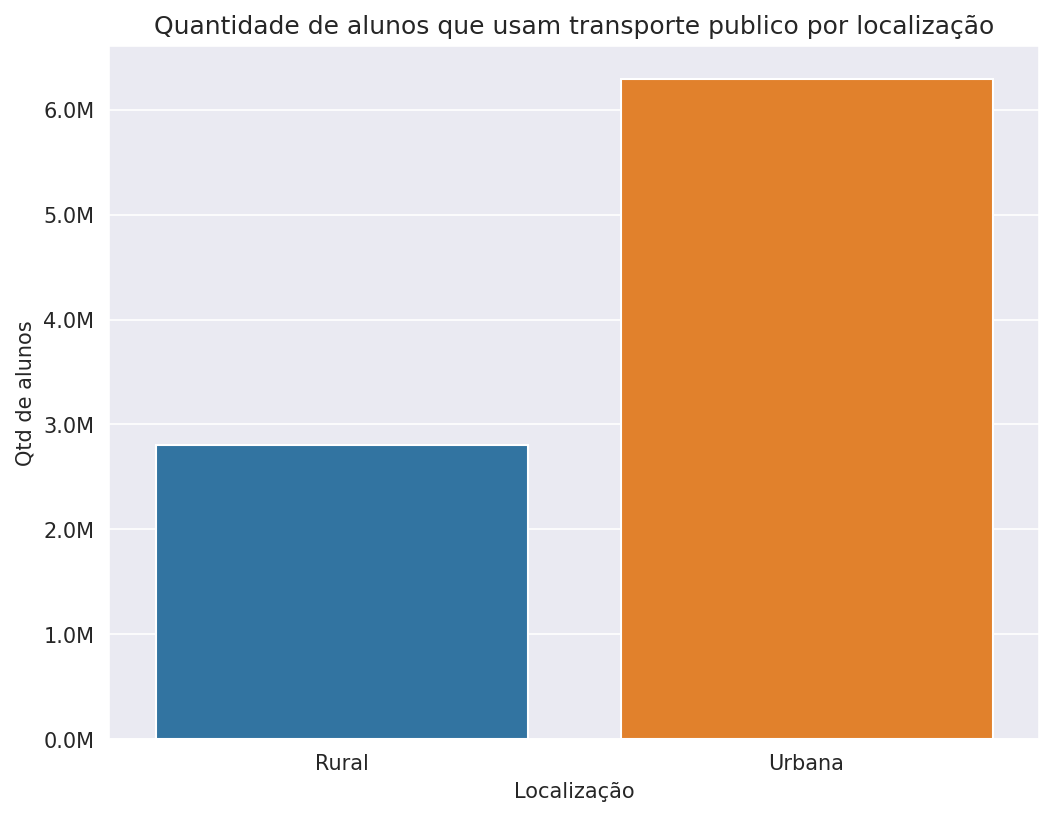

In [ ]:
#primeiro vamos fazer uma comparação de quais alunos usam mais o transporte puglico, alunos de áreas rurais ou urbanas
df_transporte = df_participação[['QT_TRANSP_PUBLICO', 'TP_LOCALIZACAO', 'TP_DEPENDENCIA', 'SG_UF', 'QT_MAT_BAS_BRANCA', 'QT_MAT_BAS_PRETA', 'QT_MAT_BAS_PARDA', 'QT_MAT_BAS_AMARELA', 'QT_MAT_BAS_INDIGENA',
                      'QT_MAT_BAS_18_MAIS',]]

df_transporte['Localização'] = df['TP_LOCALIZACAO'].map({1: 'Urbana', 2:'Rural'})
df_transporte['Tipo de escola'] = df_transporte['TP_DEPENDENCIA'].map({1 : 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})

df_rural_urbano = df_transporte.groupby('Localização')['QT_TRANSP_PUBLICO'].sum().rename('Qtd de alunos').reset_index()




plt.figure(figsize=(8,6), dpi=150)
sns.barplot(df_rural_urbano,
            x='Localização',
            y='Qtd de alunos',
            hue='Localização'
            )
plt.title('Quantidade de alunos que usam transporte publico por localização')
#como temos um valor númerico muito alto (na casa de milhoes vamos formatar nossos valores)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x/1e6:.1f}M'))
plt.savefig("Alunos_transporte_publico.png", dpi=300)
plt.show()



# Podemos ver que mais de 6 milhões de alunos de regiões urbanas se locomovem de transporte publico. E quais os tipos de escolas eles frequentam?

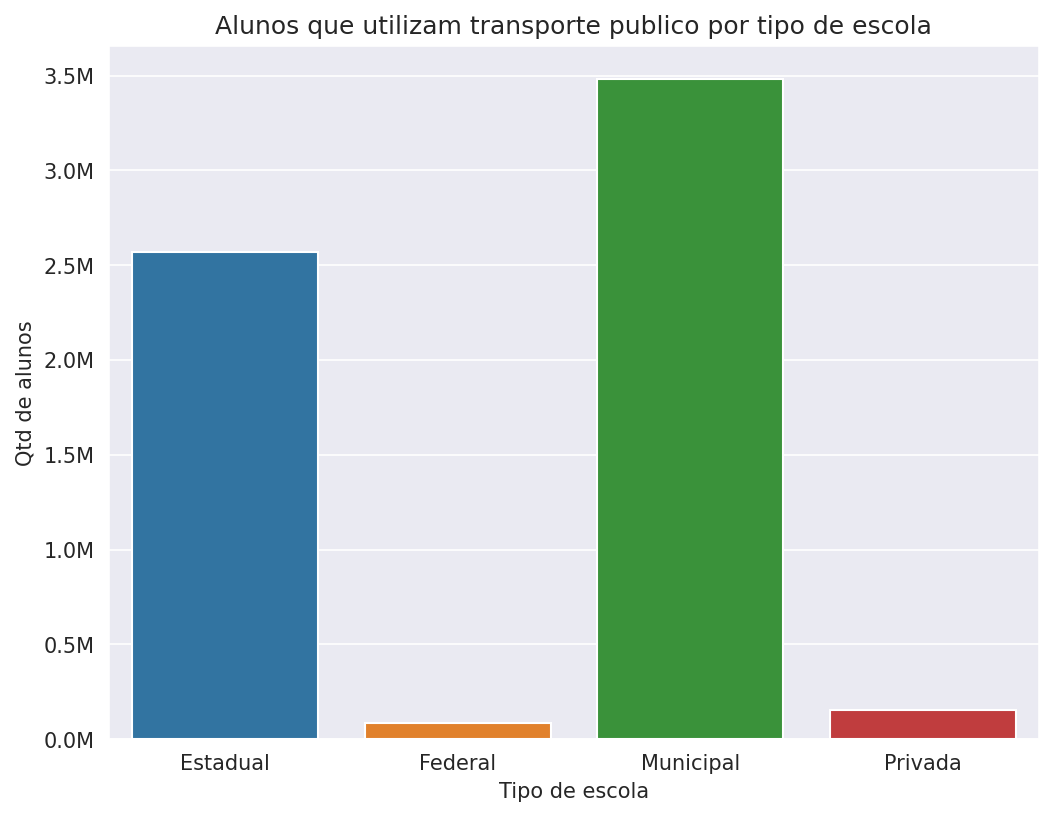

In [ ]:
df_escolas_transporte = df_transporte.query("Localização == 'Urbana'").groupby("Tipo de escola")['QT_TRANSP_PUBLICO'].sum().rename('Qtd de alunos').reset_index()
plt.figure(figsize=(8,6), dpi=150)

sns.barplot(df_escolas_transporte,
            x='Tipo de escola',
            y='Qtd de alunos',
            hue='Tipo de escola')
plt.title('Alunos que utilizam transporte publico por tipo de escola')
#novamente possuimos um muito valor alto, por isso vamos trata-los para melhor visualizacao
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x/1e6:.1f}M'))
plt.savefig("alunos_transporte_tipo_escola.png", dpi=300)
plt.show()

# Podemos ver que dentre os alunos de centros urbanos, aqueles que mais utilizam transporte publico são os alunos de redes municipais e estaduais.

# Por fim vamos analisar a proporção de professores e alunos para podermos enteder como estão as demandas nas escolas.

In [29]:
#vamos criar um data frame com a quantide de discentes e docentes da educação basica, fundamental e ensino medio
df_aluno_professor = df_participação[['CO_MUNICIPIO','QT_MAT_BAS', 'QT_DOC_BAS', 'QT_MAT_MED_INT','QT_DOC_MED', 'QT_MAT_FUND_INT', 'QT_DOC_FUND', 'TP_DEPENDENCIA', 'SG_UF']]
df_aluno_professor['Tipo de escola'] = df_aluno_professor['TP_DEPENDENCIA'].map({1 : 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})
df_aluno_professor
correlacao_aluno_professor = df_aluno_professor[['QT_MAT_BAS', 'QT_DOC_BAS', 'QT_MAT_MED_INT','QT_DOC_MED', 'QT_MAT_FUND_INT', 'QT_DOC_FUND']].corr()
correlacao_aluno_professor
plt.figure(figsize=(8,6), dpi=150)

sns.heatmap(correlacao_aluno_professor,annot=True,cmap='rocket')
plt.savefig("proporcao_aluno_professor.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipython-input-29-2623583876.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aluno_professor['Tipo de escola'] = df_aluno_professor['TP_DEPENDENCIA'].map({1 : 'Federal', 2: 'Estadual', 3: 'Municipal', 4: 'Privada'})


,QT_MAT_BAS,QT_DOC_BAS,QT_MAT_MED_INT,QT_DOC_MED,QT_MAT_FUND_INT,QT_DOC_FUND
QT_MAT_BAS,1.000000,0.862018,0.176595,0.512858,0.276367,0.679477
QT_DOC_BAS,0.862018,1.000000,0.213731,0.598503,0.293571,0.726358
QT_MAT_MED_INT,0.176595,0.213731,1.000000,0.407650,0.034057,-0.013211
QT_DOC_MED,0.512858,0.598503,0.407650,1.000000,-0.017195,0.127646
QT_MAT_FUND_INT,0.276367,0.293571,0.034057,-0.017195,1.000000,0.436045
QT_DOC_FUND,0.679477,0.726358,-0.013211,0.127646,0.436045,1.000000


# Vamos analisar a proporção de professores por aluno no Brasil

In [68]:
df_proporção_bas = df[['QT_MAT_BAS', 'QT_DOC_BAS', 'SG_UF']]

df_proporção_bas = df_proporção_bas.groupby('SG_UF')[['QT_MAT_BAS', 'QT_DOC_BAS']].sum().reset_index()
df_proporção_bas
df_proporção_bas['prop_bas'] = df_proporção_bas.QT_MAT_BAS / df_proporção_bas.QT_DOC_BAS


/tmp/ipython-input-85-1995893784.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(brasil_tipo.geometry.centroid.x,
/tmp/ipython-input-85-1995893784.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  brasil_tipo.geometry.centroid.y,


<Figure size 1200x900 with 0 Axes>

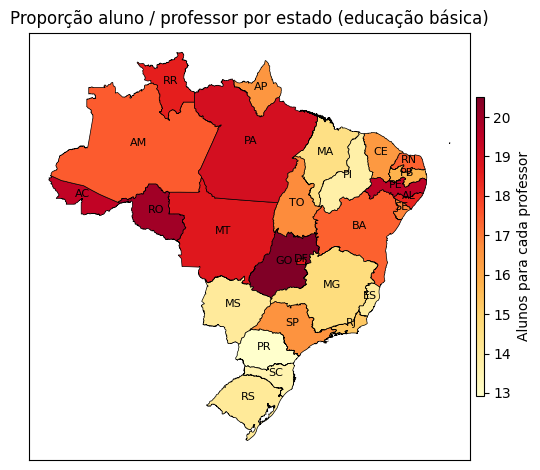

In [85]:
brasil_tipo = brasil.merge(df_proporção_bas,
                           left_on='sigla',
                           right_on='SG_UF',
                           how='left'
)

plt.figure(figsize=(8,6), dpi=150)
ax = brasil_tipo.plot(
            column='prop_bas',
            cmap='YlOrRd',
            legend=True,
            edgecolor='black',
            linewidth=0.5,
            missing_kwds={'color': 'lightgrey'},
            legend_kwds={
                'label': 'Alunos para cada professor',
                'shrink': 0.7,
                'orientation': 'vertical',
                'pad': 0.01,
                'aspect': 40
            }
        )

for x, y, label in zip(brasil_tipo.geometry.centroid.x,
                       brasil_tipo.geometry.centroid.y,
                       brasil_tipo['sigla']):
  ax.text(x, y, label, fontsize=8, ha='center', color='black')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.title('Proporção aluno / professor por estado (educação básica)')
plt.savefig('proporção_aluno_professor_bas.png', dpi=300, bbox_inches="tight")
plt.tight_layout()

In [89]:
total_mat = df_proporção_bas['QT_MAT_BAS'].sum()
total_doc = df_proporção_bas['QT_DOC_BAS'].sum()
prop_nacional = total_mat / total_doc

print(f'a proporção nacional de alunos para professores no ensino básico é: {prop_nacional}')


a proporção nacional de alunos para professores no ensino básico é: 16.02207892338964
